### Cleaned vs Dirty V2
##### Classify if a plate is cleaned or dirty?
тип задачи - классификация \
метрика качества - accuracy(доля правильных ответов) \
transfer learning - дообучение готовой архитектуры 

Основная идея решения - дообучить ResNet 

In [91]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
import copy

In [92]:
import os
import zipfile

#with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
#    zip_obj.extractall('/kaggle/working/')
#data_root = '/kaggle/working/plates/'

In [93]:
data_root = 'plates/'

Для создания train и validation выборок, создадим и заполним 2 папки:

In [94]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']
#все картинки разбиваются на классы
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
#каждая 6 картинка помещается в папку validation
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 5539.30it/s]


In [95]:
!ls train

cleaned  dirty


### Предобработка
<b>torchvision.datasets.ImageFolder</b>
 - предоставляет возможность итерирования по изображениям, запомнит в какой папке-классе оно находилось
 - помогает получать изображения в виде тензоров
 
<b>transforms.Compose</b>
 - сжатие картинки до определенного размера
 - превращение ее в тензор
 - от каждого цвета отнимаются константы, т.к. на таких примерах обучался ResNet

In [96]:
import torch
import torchvision

from torchvision import transforms, models

#Аугментации
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), #вырезается прямоугольная часть и увеличивается до 224
    transforms.RandomHorizontalFlip(), #отзеркаливание
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

In [97]:
#num_workers - количество потоков выполняющих трансформации
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

permute - меняет местами размерности тензора Х
 - до .toTenzor: высота, ширина, каналы
 - после: каналы, высота, ширина  
 
permute+обратная нормировка = исходное изображение

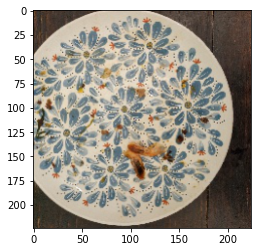

In [98]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

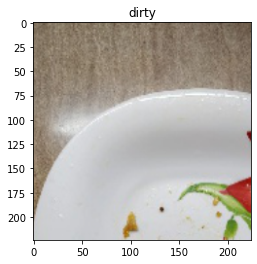

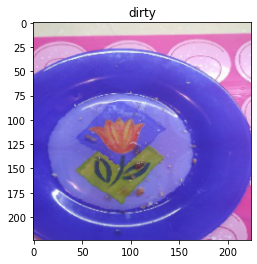

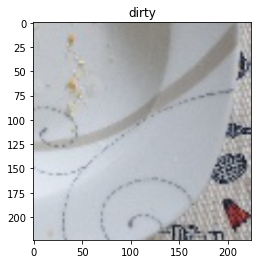

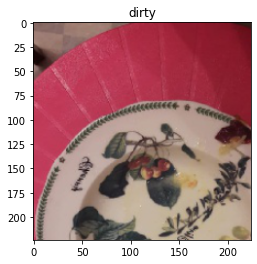

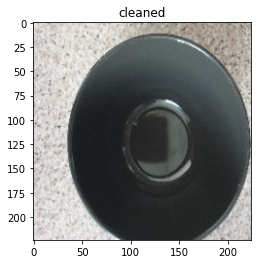

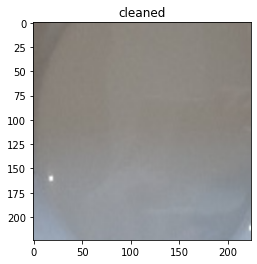

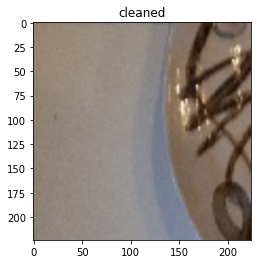

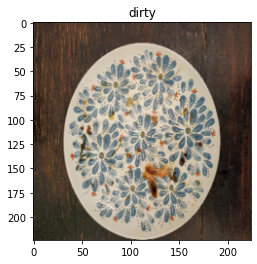

In [99]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

### Создание модели

In [100]:
model = models.resnet18(pretrained=True)

# для всех слоев отменяем вычисление градиентного спуска 
#т.к. параметры нас устраивают, модель уже обучена, осталось обучить последний слой - классификатор
for param in model.parameters():
    param.requires_grad = False


model.fc = torch.nn.Linear(model.fc.in_features, 2)


#перекладывание модели на GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#Бинарная кросс-энтропия получает активации нейронов
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3) #градиентный спуск lr - learning rate

# уменьшение lr с течением времени
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [101]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    #итератор по эпохам
    for epoch in range(num_epochs): 
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1) #чтобы узнать предсказанный класс

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [107]:
train_model(model, loss, optimizer, scheduler, num_epochs=50);

Epoch 0/49:


100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

train Loss: 0.5590 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

val Loss: 0.9282 Acc: 0.3750
Epoch 1/49:



100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

train Loss: 0.5424 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

val Loss: 0.9721 Acc: 0.5000
Epoch 2/49:



100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

train Loss: 0.5345 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

val Loss: 0.9489 Acc: 0.3750
Epoch 3/49:



100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

train Loss: 0.5679 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

val Loss: 0.9397 Acc: 0.3750
Epoch 4/49:



100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

train Loss: 0.5196 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

val Loss: 0.9368 Acc: 0.5000
Epoch 5/49:



100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

train Loss: 0.5012 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

val Loss: 0.9328 Acc: 0.5000
Epoch 6/49:



100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

train Loss: 0.5424 Acc: 0.8125



100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

val Loss: 0.9316 Acc: 0.5000
Epoch 7/49:



100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

train Loss: 0.5927 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

val Loss: 0.9501 Acc: 0.5000
Epoch 8/49:



100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

train Loss: 0.5152 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

val Loss: 0.9533 Acc: 0.5000
Epoch 9/49:



100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

train Loss: 0.5767 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

val Loss: 0.9442 Acc: 0.5000
Epoch 10/49:



100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

train Loss: 0.4518 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

val Loss: 0.9587 Acc: 0.5000
Epoch 11/49:



100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

train Loss: 0.4842 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

val Loss: 0.9638 Acc: 0.5000
Epoch 12/49:



100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

train Loss: 0.5050 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

val Loss: 0.9409 Acc: 0.5000
Epoch 13/49:



100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

train Loss: 0.5102 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

val Loss: 0.9448 Acc: 0.5000
Epoch 14/49:



100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

train Loss: 0.5043 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

val Loss: 0.9317 Acc: 0.5000
Epoch 15/49:



100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

train Loss: 0.5306 Acc: 0.7500



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

val Loss: 0.9388 Acc: 0.3750
Epoch 16/49:



100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

train Loss: 0.5692 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

val Loss: 0.9461 Acc: 0.5000
Epoch 17/49:



100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

train Loss: 0.5478 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.9402 Acc: 0.5000
Epoch 18/49:



100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

train Loss: 0.5214 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

val Loss: 0.9450 Acc: 0.5000
Epoch 19/49:



100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

train Loss: 0.5618 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

val Loss: 0.9426 Acc: 0.5000
Epoch 20/49:



100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

train Loss: 0.5031 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

val Loss: 0.9255 Acc: 0.5000
Epoch 21/49:



100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

train Loss: 0.5737 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

val Loss: 0.9346 Acc: 0.6250
Epoch 22/49:



100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

train Loss: 0.5630 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

val Loss: 0.9115 Acc: 0.6250
Epoch 23/49:



100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

train Loss: 0.5231 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

val Loss: 0.9148 Acc: 0.6250
Epoch 24/49:



100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

train Loss: 0.5523 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

val Loss: 0.9228 Acc: 0.6250
Epoch 25/49:



100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

train Loss: 0.5074 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

val Loss: 0.9301 Acc: 0.3750
Epoch 26/49:



100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

train Loss: 0.4921 Acc: 0.8438



100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

val Loss: 0.9343 Acc: 0.3750
Epoch 27/49:



100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

train Loss: 0.5206 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

val Loss: 0.9274 Acc: 0.3750
Epoch 28/49:



100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

train Loss: 0.5309 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

val Loss: 0.9482 Acc: 0.3750
Epoch 29/49:



100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

train Loss: 0.5626 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

val Loss: 0.9364 Acc: 0.6250
Epoch 30/49:



100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

train Loss: 0.5465 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

val Loss: 0.9363 Acc: 0.6250
Epoch 31/49:



100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

train Loss: 0.4957 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

val Loss: 0.9313 Acc: 0.6250
Epoch 32/49:



100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

train Loss: 0.4861 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

val Loss: 0.9334 Acc: 0.6250
Epoch 33/49:



100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

train Loss: 0.5197 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

val Loss: 0.9156 Acc: 0.5000
Epoch 34/49:



100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

train Loss: 0.4761 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

val Loss: 0.9311 Acc: 0.6250
Epoch 35/49:



100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

train Loss: 0.5659 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

val Loss: 0.9270 Acc: 0.6250
Epoch 36/49:



100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

train Loss: 0.5018 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

val Loss: 0.9259 Acc: 0.5000
Epoch 37/49:



100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

train Loss: 0.5125 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

val Loss: 0.9334 Acc: 0.6250
Epoch 38/49:



100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

train Loss: 0.6025 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

val Loss: 0.9478 Acc: 0.6250
Epoch 39/49:



100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

train Loss: 0.5350 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

val Loss: 0.9400 Acc: 0.6250
Epoch 40/49:



100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

train Loss: 0.5656 Acc: 0.6562



100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

val Loss: 0.9386 Acc: 0.5000
Epoch 41/49:



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

train Loss: 0.4890 Acc: 0.7188



100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

val Loss: 0.9384 Acc: 0.3750
Epoch 42/49:



100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

train Loss: 0.5048 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

val Loss: 0.9206 Acc: 0.6250
Epoch 43/49:



100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

train Loss: 0.4543 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

val Loss: 0.9369 Acc: 0.6250
Epoch 44/49:



100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

train Loss: 0.4604 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

val Loss: 0.9383 Acc: 0.6250
Epoch 45/49:



100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

train Loss: 0.4666 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

val Loss: 0.9428 Acc: 0.5000
Epoch 46/49:



100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

train Loss: 0.4985 Acc: 0.8438



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

val Loss: 0.9372 Acc: 0.5000
Epoch 47/49:



100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

train Loss: 0.5475 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

val Loss: 0.9438 Acc: 0.5000
Epoch 48/49:



100%|██████████| 4/4 [00:02<00:00,  1.33it/s]

train Loss: 0.5781 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

val Loss: 0.9384 Acc: 0.5000
Epoch 49/49:



100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

train Loss: 0.5340 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

val Loss: 0.9170 Acc: 0.5000


In [110]:
test_dir = 'test1'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test1/unknown'

In [111]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [112]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [113]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:52<00:00,  1.76it/s]


In [119]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

submission_df.head()

,id,label
0,test/unknown/0000.jpg,0.934564
1,test/unknown/0001.jpg,0.569414
2,test/unknown/0002.jpg,0.664222
3,test/unknown/0003.jpg,0.956401
4,test/unknown/0004.jpg,0.602825


In [120]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
...,...
0739,dirty
0740,dirty
0741,dirty


In [122]:
submission_df[submission_df.label =='cleaned'].count()

label    150
dtype: int64

In [123]:
submission_df[submission_df.label =='dirty'].count()

label    594
dtype: int64

In [124]:
submission_df.to_csv('submission.csv')

In [125]:
!rm -rf train val test